In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import shap
from lime.lime_tabular import LimeTabularExplainer


In [2]:
file_path_2018 = "./eng_967_2018.csv"
file_path_2019 = "./eng_967_2019.csv"

data_2018 = pd.read_csv(file_path_2018) 
data_2019 = pd.read_csv(file_path_2019)

In [3]:
# Inspect the columns of each DataFrame
print(data_2018.columns)
print(data_2019.columns)

Index(['Aquatic body name', 'Cross-sectional name', 'Cross-sectional code',
       'month', 'pH', 'dissolved oxygen', 'Potassium monate index',
       'Biochemical oxygen demand', 'Ammonia nitrogen', 'Total phosphorus',
       'Total nitrogen', 'copper', 'zinc', 'fluoride', 'selenium', 'arsenic',
       'mercury', 'cadmium', 'Hexavalent chromium', 'lead', 'cyanide',
       'Volatile phenols', 'Petroleum', 'Anionic surfactants', 'sulfide',
       'Chlorophyll', 'transparency', 'Eutrophic index', 'Eutrophication',
       'Chemical oxygen demand'],
      dtype='object')
Index(['Cross-sectional name', 'region', 'month', 'target', 'status quo',
       'Whether the standard is met', 'pH', 'dissolved oxygen',
       'Potassium monate index', 'Biochemical oxygen demand',
       'Ammonia nitrogen', 'Petroleum', 'Volatile phenols', 'mercury', 'lead',
       'Total phosphorus', 'copper', 'zinc', 'fluoride', 'selenium', 'arsenic',
       'cadmium', 'Hexavalent chromium', 'cyanide', 'Anionic surfac

In [4]:
# Find common columns
common_columns = data_2018.columns.intersection(data_2019.columns)
print(common_columns)
common_columns.shape[0]

Index(['Cross-sectional name', 'month', 'pH', 'dissolved oxygen',
       'Potassium monate index', 'Biochemical oxygen demand',
       'Ammonia nitrogen', 'Total phosphorus', 'copper', 'zinc', 'fluoride',
       'selenium', 'arsenic', 'mercury', 'cadmium', 'Hexavalent chromium',
       'lead', 'cyanide', 'Volatile phenols', 'Petroleum',
       'Anionic surfactants', 'sulfide', 'Chemical oxygen demand'],
      dtype='object')


23

In [5]:
df = pd.concat([data_2018, data_2019], ignore_index=True)
cols = [col for col in df.columns if col != 'Chemical oxygen demand'] + ['Chemical oxygen demand']
df = df[cols]

print(df.head)
# file_path = "concatenated_data.xlsx"
# df.to_excel(file_path, index=False)

<bound method NDFrame.head of     Aquatic body name Cross-sectional name  Cross-sectional code  month    pH  \
0         Hongze Lake     Chenghe Township                  52.0      1  8.20   
1         Hongze Lake     Chenghe Township                  52.0      2  8.50   
2         Hongze Lake     Chenghe Township                  52.0      3  8.40   
3         Hongze Lake     Chenghe Township                  52.0      4  8.40   
4         Hongze Lake     Chenghe Township                  52.0      5  8.50   
..                ...                  ...                   ...    ...   ...   
115               NaN  Llama Lake Township                   NaN      8  8.24   
116               NaN  Llama Lake Township                   NaN      9  8.30   
117               NaN  Llama Lake Township                   NaN     10  8.14   
118               NaN  Llama Lake Township                   NaN     11  8.54   
119               NaN  Llama Lake Township                   NaN     12  8.27  

In [6]:
print(f"Data dimensions: data_2018: {data_2018.shape}, data_2019: {data_2019.shape}")
print(f"Data dimensions: merged_data: {df.shape}")

Data dimensions: data_2018: (60, 30), data_2019: (60, 27)
Data dimensions: merged_data: (120, 34)


### Checking Missing values


In [7]:
print(f"Number of variables with missing instances: {sum(df.isna().any())}")

Number of variables with missing instances: 11


In [8]:
duplicates = df.duplicated()
duplicates.any()

False

In [9]:
z = df.isna().any()
z = z.loc[lambda x: x == True]
with_missing = list(z.index)

# count missing instances for each feature
missingCounts = {}
for c in with_missing:
    missingCounts[c] = sum(df[c].isna())

print("Number of Missing instances for each feature")
missingCounts

Number of Missing instances for each feature


{'Aquatic body name': 60,
 'Cross-sectional code': 60,
 'Total nitrogen': 60,
 'Chlorophyll': 60,
 'transparency': 60,
 'Eutrophic index': 70,
 'Eutrophication': 70,
 'region': 60,
 'target': 60,
 'status quo': 60,
 'Whether the standard is met': 60}

In [10]:
# Drop unnecessary columns for regression
drop_columns = ['Aquatic body name', 'Cross-sectional name', 'Cross-sectional code', 'selenium', 'Hexavalent chromium', 'Volatile phenols', 'Chemical oxygen demand']

# Extract target variable
target = df['Chemical oxygen demand']

df = df.drop(columns=drop_columns)

# Check the data types of the columns to identify non-numeric columns
data_types = df.dtypes
non_numeric_columns = data_types[data_types == 'object'].index.tolist()

print("Non-numeric columns before filtering:", non_numeric_columns)

# Clean non-numeric characters in specific columns that should be numeric
columns_to_clean = ['zinc', 'mercury', 'cadmium', 'cyanide', 'Petroleum', 'Anionic surfactants', 'sulfide']
for col in columns_to_clean:
    if col in non_numeric_columns:
        df[col] = df[col].replace({'L': ''}, regex=True).astype(float)

# Re-check the data types after cleaning
data_types = df.dtypes
non_numeric_columns = data_types[data_types == 'object'].index.tolist()

print("Non-numeric columns after cleaning:", non_numeric_columns)

Non-numeric columns before filtering: ['zinc', 'mercury', 'cadmium', 'cyanide', 'Petroleum', 'Anionic surfactants', 'sulfide', 'Eutrophication', 'region']
Non-numeric columns after cleaning: ['Eutrophication', 'region']


### Train Test Split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.1, random_state=42)

In [12]:
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

Training data shape: (108, 27)
Testing data shape: (12, 27)


### Handling Missing values

In [13]:
def replace_missing(df):
    # Identify numeric and non-numeric features
    numeric_features = df.select_dtypes(include=['number']).columns
    non_numeric_features = df.select_dtypes(exclude=['number']).columns

    # Handle numeric columns by filling missing values with the median
    for f in numeric_features:
        if df[f].isna().any():
            df[f] = df[f].fillna(df[f].median())

    return df
# Assuming X_train and X_test are your train and test dataframes
X_train = replace_missing(X_train)
X_test = replace_missing(X_test)

In [14]:
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

Training data shape: (108, 27)
Testing data shape: (12, 27)


In [15]:
X_test.head()

month    pH  dissolved oxygen  Potassium monate index  \
44      8  8.40               7.2                     3.5   
47     12  7.86              11.2                     2.7   
4       5  8.50               8.1                     3.4   
55      8  8.20               6.7                     3.5   
26      3  8.30              10.2                     3.8   

    Biochemical oxygen demand  Ammonia nitrogen  Total phosphorus  \
44                        2.3              0.06              0.02   
47                        3.3              0.21              0.05   
4                         2.5              0.32              0.10   
55                        2.1              0.08              0.03   
26                        1.5              0.08              0.11   

    Total nitrogen   copper    zinc  ...  Anionic surfactants  sulfide  \
44             0.7  0.00300  0.0004  ...                 0.02    0.002   
47             2.3  0.00084  0.0007  ...                 0.05    0.005   
4              2.1  0.00050  0.0200  ...                 0.02    0.014   
55             0.7  0.00200  0.0004  ...                 0.02    0.002   
26             1.4  0.00100  0.0100  ...                 0.02    0.002   

    Chlorophyll  transparency  Eutrophic index    Eutrophication  region  \
44        0.010         125.0             42.7  Medium nutrition     NaN   
47        0.013          65.0             49.9               NaN     NaN   
4         0.005          37.0             53.0        Light rich     NaN   
55        0.025         110.0             46.8  Medium nutrition     NaN   
26        0.015          33.0             56.2        Light rich     NaN   

    target  status quo  Whether the standard is met  
44     4.0         3.0                          1.0  
47     4.0         3.0                          1.0  
4      4.0         3.0                          1.0  
55     4.0         3.0                          1.0  
26     4.0         3.0                          1.0  

[5 rows x 27 columns]

### Correlation analysis

Missing values in the correlation matrix:
 0


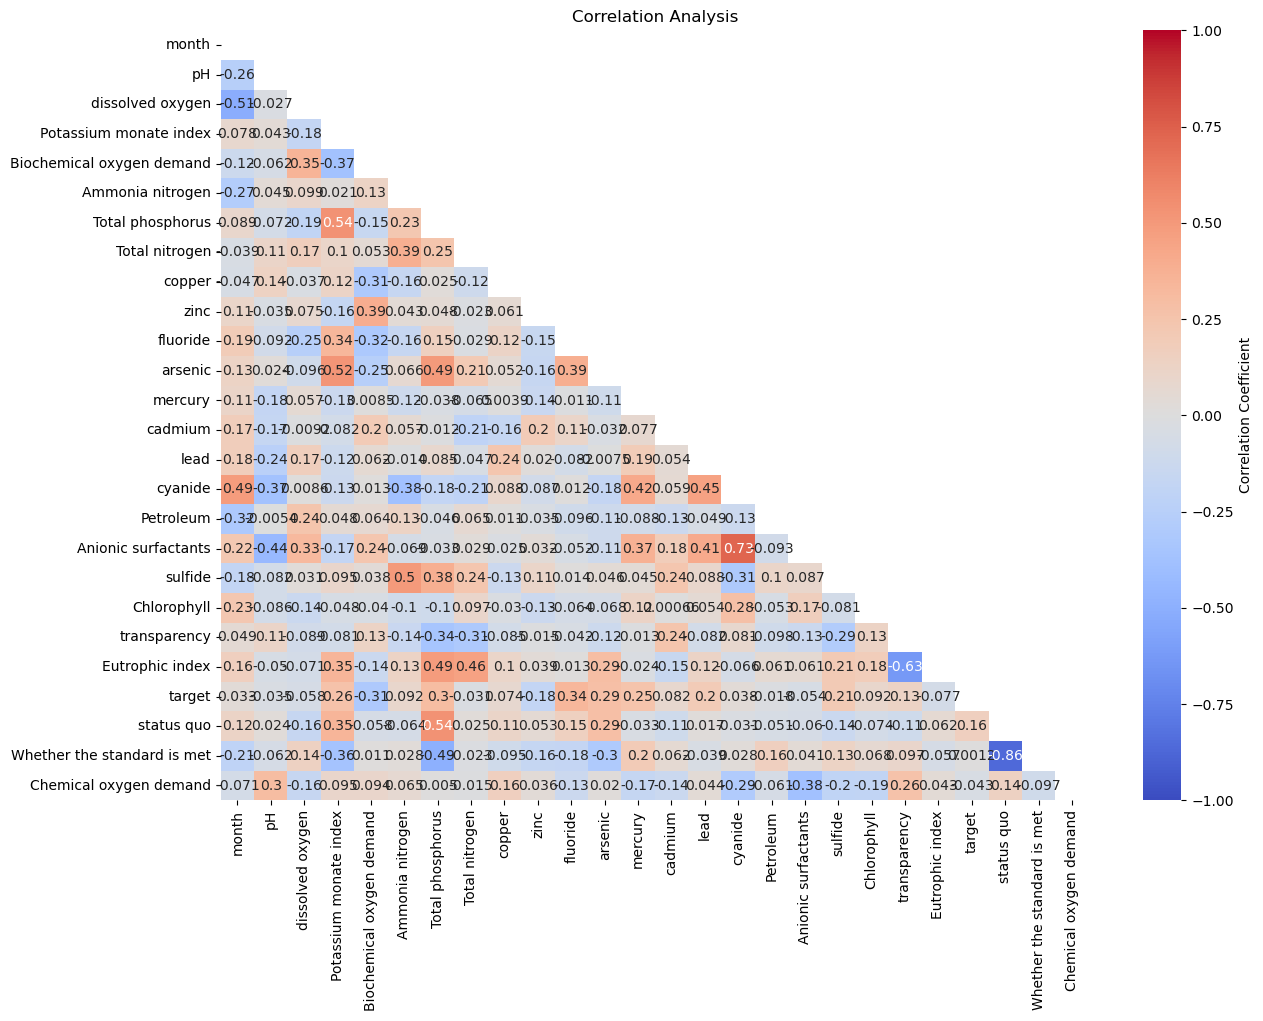

In [16]:
exclude = ['Aquatic body name', 'Cross-sectional name', 'Cross-sectional code', 'Eutrophication']
df_train = pd.concat([X_train, y_train], axis=1)
features_corr = [c for c in df_train.columns if c not in exclude]
numeric_features = df_train[features_corr].select_dtypes(include=['number']).columns

# Compute the correlation matrix
corrMat = df_train[numeric_features].corr()

# Check for missing values in the correlation matrix
print("Missing values in the correlation matrix:\n", corrMat.isna().sum().sum())

# Fill missing values with zero or another appropriate value
corrMat = corrMat.fillna(0)

# Generate a mask for the upper triangle
mask = np.zeros_like(corrMat)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMat, vmin=-1, vmax=1, annot=True, mask=mask, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Analysis')
plt.show()


In [17]:
corFeatureTar = corrMat['Chemical oxygen demand'].drop(labels = ['Chemical oxygen demand']).sort_values(ascending=True)

#### Identify highly correlated variables

In [18]:
# Initialize an empty list to store correlated variable pairs
highly_corr_pairs_numeric = []

# Iterate over each column in the correlation matrix
for col in corrMat.columns:
    # Find variables with correlation greater than 0.5
    high_corr_vars = corrMat[abs(corrMat[col]) > 0.5].index.to_list()

    # If there are more than one highly correlated variables
    if len(high_corr_vars) > 1:
        # Add the pairs to the list
        for var in high_corr_vars:
            if var != col and (var, col) not in highly_corr_pairs_numeric:
                highly_corr_pairs_numeric.append((col, var))

# Print the list of highly correlated variable pairs
print("Highly correlated variable pairs:")
for pair in highly_corr_pairs_numeric:
    print(pair)


Highly correlated variable pairs:
('month', 'dissolved oxygen')
('Potassium monate index', 'Total phosphorus')
('Potassium monate index', 'arsenic')
('Total phosphorus', 'status quo')
('cyanide', 'Anionic surfactants')
('transparency', 'Eutrophic index')
('status quo', 'Whether the standard is met')


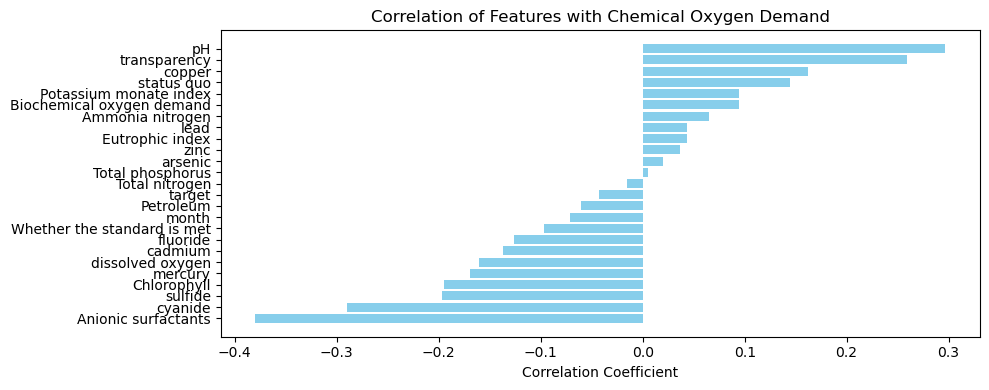

In [19]:
# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
plt.barh(corFeatureTar.index, corFeatureTar, color='skyblue')
plt.title('Correlation of Features with Chemical Oxygen Demand')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()

## Standardisation

In [20]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Select only numeric features for standardization
numeric_features = X_train.select_dtypes(include=['number']).columns
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Convert the scaled arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

# Check the scaled data
print("Scaled Training Data Shape:", X_train_scaled_df.shape)
print("Scaled Training Data Shape:", y_train.shape)
print("Scaled Testing Data Shape:", X_test_scaled_df.shape)



Scaled Training Data Shape: (108, 25)
Scaled Training Data Shape: (108,)
Scaled Testing Data Shape: (12, 25)


In [21]:
features = X_train.columns.to_list()

In [22]:
print(len(features))

27


In [23]:
r2_accuracy=[]
mse_accuracy=[]
rmse_accuracy=[]
mae_accuracy=[]
algorithm_name=[]

In [24]:
r2_accuracy_rfe=[]
mse_accuracy_rfe=[]
rmse_accuracy_rfe=[]
mae_accuracy_rfe=[]
algorithm_name_rfe=[]

## Random Forest

In [25]:
# Define the features (excluding 'Eutrophication' and 'region')
features = [col for col in X_train.columns if col not in ['Eutrophication', 'region']]

# Define the preprocessing steps
scaler = Pipeline([('scaler', RobustScaler())])

# Applying standardization to the numerical features and one-hot encoding to 'Eutrophication' and 'region'
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Define the transformed target regressor with RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
target_transformer = TransformedTargetRegressor(regressor=rf, func=np.log, inverse_func=np.exp)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), ('target_transformer', target_transformer)])

# Define the hyperparameter grid for grid search
param_grid = {
    'target_transformer__regressor__n_estimators': [100, 300],
    'target_transformer__regressor__max_depth': [3, 5, 10],
    'target_transformer__regressor__min_samples_split': [2, 5, 10],
    'target_transformer__regressor__min_samples_leaf': [1, 2, 4],
    'target_transformer__regressor__max_features': ['auto', 'sqrt'],
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
model = grid_search.fit(X_train, y_train)
best_model_rf = model.best_estimator_

# Predictions and evaluation on test set
y_pred_rf = best_model_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_rf = {
    'algorithm': ['Random Forest'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

# Display results
res_rf

r2_accuracy.append(r2)
mse_accuracy.append(mse_n)
rmse_accuracy.append(rmse_n)
mae_accuracy.append(mae_n)
algorithm_name.append('Random Forest')


In [26]:
print(res_rf)

{'algorithm': ['Random Forest'], 'MAE Test': [0.14822585883186412], 'R² Test': [0.5079670757047507], 'MSE Test': [0.0329034362954642], 'RMSE Test': [0.1813930436799168]}


In [27]:
# Define the preprocessing steps
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Create a pipeline for preprocessing
preprocess_pipeline = Pipeline(steps=[('preprocess', transformer)])

# Apply preprocessing to the data
X_train_preprocessed = preprocess_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocess_pipeline.transform(X_test)

# Define the base model
rf = RandomForestRegressor(random_state=42)

rfe = RFE(estimator=rf, n_features_to_select=9)

# Define the transformed target regressor
target_transformer = TransformedTargetRegressor(regressor=rfe, func=np.log, inverse_func=np.exp)

# Create the pipeline with RFE included
pipeline = Pipeline(steps=[
    ('target_transformer', target_transformer)
])

# Define the hyperparameter grid for grid search
param_grid = {
    'target_transformer__regressor__estimator__n_estimators': [100, 300],
    'target_transformer__regressor__estimator__max_depth': [3, 5, 10],
    'target_transformer__regressor__estimator__min_samples_split': [2, 5, 10],
    'target_transformer__regressor__estimator__min_samples_leaf': [1, 2, 4],
    'target_transformer__regressor__estimator__max_features': ['auto', 'sqrt'],
}

# Perform grid search with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
model = grid_search.fit(X_train_preprocessed, y_train)
best_model_rf_rfe = model.best_estimator_

# Predictions and evaluation on test set
y_pred_rf = best_model_rf_rfe.predict(X_test_preprocessed)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_rf = {
    'algorithm': ['Random Forest with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_rf

r2_accuracy_rfe.append(r2)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('Random Forest with RFE')


In [28]:
print(res_rf)

{'algorithm': ['Random Forest with RFE'], 'MAE Test': [0.1341101990444068], 'R² Test': [0.6266348879310101], 'MSE Test': [0.02496783156839953], 'RMSE Test': [0.15801212475123397]}


## SVR

In [29]:
# Update the list of features to include all features except 'Eutrophication'
features = [col for col in X_train.columns if col not in ['Eutrophication', 'region']]

# Applying standardization to the numerical features and one-hot encoding to 'Eutrophication' and 'region'
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Define the transformed target regressor
regressor = SVR()
target_transformer = TransformedTargetRegressor(regressor=regressor, func=np.log, inverse_func=np.exp)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), ('transform_target', target_transformer)])

# Define the hyperparameter grid for grid search
param_grid = {
    'transform_target__regressor__C': np.linspace(0.01, 1, 10),
    'transform_target__regressor__kernel': ['linear'],
    'transform_target__regressor__gamma': np.linspace(0.001, 10)
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
models = grid_search.fit(X_train, y_train)
best_model = models.best_estimator_

# Predictions and evaluation on test set
y_pred_svr = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)

mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)
rmse_n = rmse / range_y_test

# Save results
res_svr = {
    'algorithm': ['SVR'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

r2_accuracy.append(r2)
mse_accuracy.append(mse_n)
rmse_accuracy.append(rmse_n)
mae_accuracy.append(mae_n)
algorithm_name.append('SVR')


In [30]:
# Define the preprocessing steps
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Create a pipeline for preprocessing
preprocess_pipeline = Pipeline(steps=[('preprocess', transformer)])

# Apply preprocessing to the data
X_train_preprocessed = preprocess_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocess_pipeline.transform(X_test)

# Define the base model
svr = SVR()

rfe = RFE(estimator=svr, n_features_to_select=15)

# Define the transformed target regressor
target_transformer = TransformedTargetRegressor(regressor=rfe, func=np.log, inverse_func=np.exp)

# Create the pipeline with RFE included
pipeline = Pipeline(steps=[
    ('target_transformer', target_transformer)
])

# Define the hyperparameter grid for grid search
param_grid = {
    'target_transformer__regressor__estimator__C': [0.1, 1, 10],
    'target_transformer__regressor__estimator__epsilon': [0.01, 0.1, 0.2],
    'target_transformer__regressor__estimator__kernel': ['linear', 'rbf', 'poly'],
    'target_transformer__regressor__estimator__degree': [2, 3, 4],  # Used only with 'poly' kernel
    'target_transformer__regressor__estimator__gamma': ['scale', 'auto'],
}

# Perform grid search with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
model = grid_search.fit(X_train_preprocessed, y_train)
best_model_svr_rfe = model.best_estimator_

# Predictions and evaluation on test set
y_pred_svr = best_model_svr_rfe.predict(X_test_preprocessed)
mae = mean_absolute_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)

mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)
rmse_n = rmse / range_y_test

# Save results
res_svr = {
    'algorithm': ['SVR with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

r2_accuracy_rfe.append(r2)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('SVR with RFE')


In [31]:
# Define the features (excluding 'Eutrophication' and 'region')
features = [col for col in X_train.columns if col not in ['Eutrophication', 'region']]

# Define the preprocessing steps
scaler = Pipeline([('scaler', RobustScaler())])

# Applying standardization to the numerical features and one-hot encoding to 'Eutrophication' and 'region'
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Define the MLPRegressor model
mlp = MLPRegressor(random_state=42, max_iter=1000)

# Define the transformed target regressor
target_transformer = TransformedTargetRegressor(regressor=mlp, func=np.log, inverse_func=np.exp)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), ('target_transformer', target_transformer)])

# Define the hyperparameter grid for grid search
param_grid = {
    'target_transformer__regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'target_transformer__regressor__activation': ['relu', 'tanh'],
    'target_transformer__regressor__solver': ['adam', 'lbfgs'],
    'target_transformer__regressor__alpha': [0.0001, 0.001, 0.01],
    'target_transformer__regressor__learning_rate': ['constant', 'adaptive'],
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
model = grid_search.fit(X_train, y_train)
best_model_ann = model.best_estimator_

# Predictions and evaluation on test set
y_pred_ann = best_model_ann.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_ann)
r2 = r2_score(y_test, y_pred_ann)

mse = mean_squared_error(y_test, y_pred_ann)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)
rmse_n = rmse / range_y_test

# Save results
res_ann = {
    'algorithm': ['ANN'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

r2_accuracy.append(r2)
mse_accuracy.append(mse_n)
rmse_accuracy.append(rmse_n)
mae_accuracy.append(mae_n)
algorithm_name.append('ANN')


In [32]:
print(res_ann)

{'algorithm': ['ANN'], 'MAE Test': [0.16582950503088972], 'R² Test': [0.28537442822603853], 'MSE Test': [0.04778874708364969], 'RMSE Test': [0.21860637475528863]}


In [33]:
# Define the preprocessing steps
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Create a pipeline for preprocessing
preprocess_pipeline = Pipeline(steps=[('preprocess', transformer)])

# Apply preprocessing to the data
X_train_preprocessed = preprocess_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocess_pipeline.transform(X_test)
    
# Use RandomForestRegressor to select important features
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold=-np.inf, max_features=13)
X_train_selected = selector.fit_transform(X_train_preprocessed, y_train)
X_test_selected = selector.transform(X_test_preprocessed)

# Define the MLPRegressor model
mlp = MLPRegressor(random_state=42, max_iter=1000)

# Define the transformed target regressor
target_transformer = TransformedTargetRegressor(regressor=mlp, func=np.log, inverse_func=np.exp)

# Create the pipeline
pipeline = Pipeline(steps=[('target_transformer', target_transformer)])

# Define the hyperparameter grid for grid search
param_grid = {
    'target_transformer__regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'target_transformer__regressor__activation': ['relu', 'tanh'],
    'target_transformer__regressor__solver': ['adam', 'lbfgs'],
    'target_transformer__regressor__alpha': [0.0001, 0.001, 0.01],
    'target_transformer__regressor__learning_rate': ['constant', 'adaptive'],
}

# Perform grid search with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
model = grid_search.fit(X_train_selected, y_train)
best_model_ann = model.best_estimator_

# Predictions and evaluation on test set
y_pred_ann = best_model_ann.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred_ann)
r2 = r2_score(y_test, y_pred_ann)

mse = mean_squared_error(y_test, y_pred_ann)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)
rmse_n = rmse / range_y_test

# Save results
res_ann = {
    'algorithm': ['ANN with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

print(res_ann)

r2_accuracy_rfe.append(r2)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('ANN with RFE')


{'algorithm': ['ANN with RFE'], 'MAE Test': [0.1322272408608443], 'R² Test': [0.5352258046186444], 'MSE Test': [0.03108057890924703], 'RMSE Test': [0.1762968488352728]}


## XGBOOST

In [34]:
features = [col for col in X_train.columns if col not in ['Eutrophication', 'region']]

# Define the preprocessing steps
scaler = Pipeline([('scaler', RobustScaler())])

# Applying standardization to the numerical features and one-hot encoding to 'Eutrophication'
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Define the transformed target regressor
xgb = XGBRegressor(random_state=42)
target_transformer = TransformedTargetRegressor(regressor=xgb, func=np.log, inverse_func=np.exp)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), ('target_transformer', target_transformer)])

# Define the hyperparameter grid for grid search
param_grid = {
    'target_transformer__regressor__learning_rate': [0.001, 0.05, 0.09],
    'target_transformer__regressor__max_depth': [3, 4, 6, 10],
    'target_transformer__regressor__gamma': [0.01, 0.02],
    'target_transformer__regressor__n_estimators': [100, 300],
    'target_transformer__regressor__reg_lambda': [1, 3, 5],
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
model = grid_search.fit(X_train, y_train)
best_model_xgb = model.best_estimator_

# Predictions and evaluation on test set
y_pred_xgb = best_model_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_xgb = {
    'algorithm': ['XGBoost with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

# Display results
res_xgb

r2_accuracy.append(r2)
mse_accuracy.append(mse_n)
rmse_accuracy.append(rmse_n)
mae_accuracy.append(mae_n)
algorithm_name.append('XGBoost')


In [36]:
# Define the preprocessing steps
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Create a pipeline for preprocessing
# preprocess_pipeline = Pipeline(steps=[('preprocess', transformer)])

# Apply preprocessing to the data
X_train_preprocessed = transformer.fit_transform(X_train)
X_test_preprocessed = transformer.transform(X_test)

# Define the base model
xgb = XGBRegressor(random_state=42)
rfe = RFE(estimator=xgb, n_features_to_select=22)
rfe.fit(X_train_preprocessed, y_train)

# Get the names of the selected features
selected_feature_names = np.array(transformer.get_feature_names_out())[rfe.support_]
print("Selected feature names: ", selected_feature_names)

# # Now use the selected features for the final model
X_train_selected = rfe.transform(X_train_preprocessed)
X_test_selected = rfe.transform(X_test_preprocessed)


# Define the transformed target regressor
target_transformer = TransformedTargetRegressor(regressor=rfe, func=np.log, inverse_func=np.exp)

# Create the pipeline with RFE included
pipeline = Pipeline(steps=[
    ('target_transformer', target_transformer)
])

# Define the hyperparameter grid for grid search
param_grid = {
    'target_transformer__regressor__estimator__learning_rate': [0.001, 0.05, 0.09],
    'target_transformer__regressor__estimator__max_depth': [3, 4, 6, 10],
    'target_transformer__regressor__estimator__gamma': [0.01, 0.02],
    'target_transformer__regressor__estimator__n_estimators': [100, 300],
    'target_transformer__regressor__estimator__reg_lambda': [1, 3, 5],
}

# Perform grid search with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
model = grid_search.fit(X_train_selected, y_train)
best_model_xgb_rfe = model.best_estimator_

# Predictions and evaluation on test set
y_pred_xgb = best_model_xgb_rfe.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_xgb = {
    'algorithm': ['XGBoost with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

# Display results
res_xgb

r2_accuracy_rfe.append(r2)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('XGBoost with RFE')


Selected feature names:  ['scaler__month' 'scaler__pH' 'scaler__dissolved oxygen'
 'scaler__Potassium monate index' 'scaler__Biochemical oxygen demand'
 'scaler__Ammonia nitrogen' 'scaler__Total phosphorus'
 'scaler__Total nitrogen' 'scaler__copper' 'scaler__zinc'
 'scaler__fluoride' 'scaler__arsenic' 'scaler__cadmium' 'scaler__lead'
 'scaler__cyanide' 'scaler__Petroleum' 'scaler__Anionic surfactants'
 'scaler__sulfide' 'scaler__Chlorophyll' 'scaler__transparency'
 'scaler__Eutrophic index' 'onehot__region_Sihong County']


In [37]:
best_model_xgb_rfe.named_steps.target_transformer.regressor_.estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.02, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

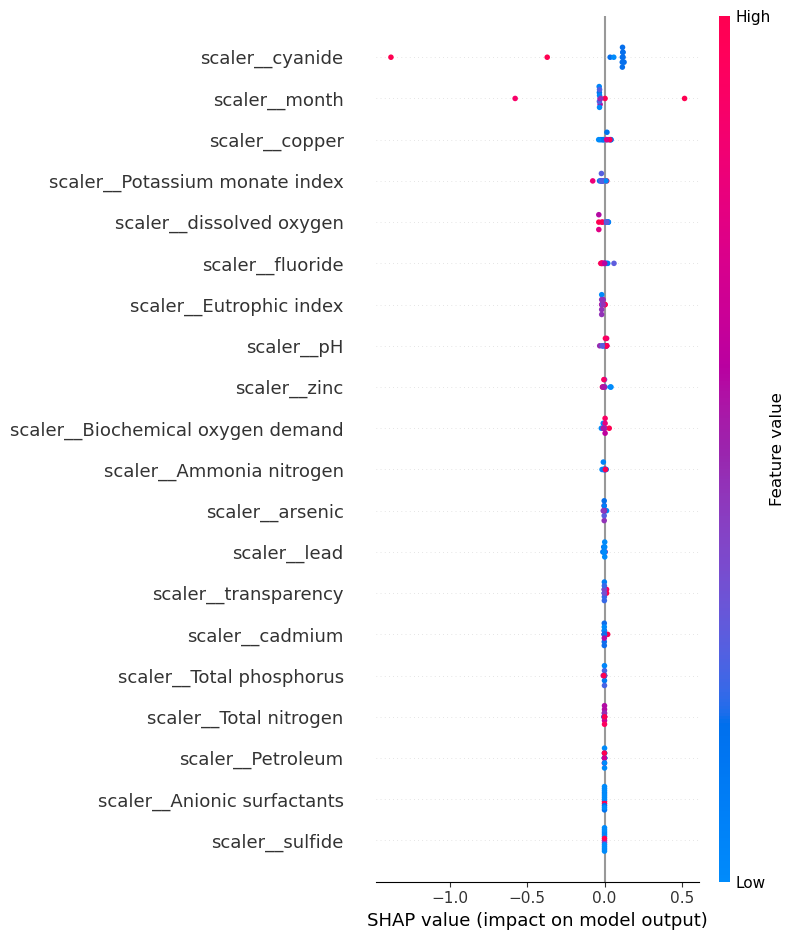

{'algorithm': ['XGBoost with RFE'],
 'MAE Test': [0.09801267308217508],
 'R² Test': [0.7935803794470608],
 'MSE Test': [0.013803781209815891],
 'RMSE Test': [0.1174894940401732]}

In [38]:
# SHAP Integration
explainer = shap.TreeExplainer(best_model_xgb_rfe.named_steps.target_transformer.regressor_.estimator_)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_selected)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names)

# LIME Integration
lime_explainer = LimeTabularExplainer(
    training_data=X_train_selected, 
    feature_names=selected_feature_names, 
    class_names=['target'], 
    mode='regression'
)


# Predictions and evaluation on test set
y_pred_xgb = best_model_xgb_rfe.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_xgb = {
    'algorithm': ['XGBoost with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

# Display results
res_xgb


In [39]:
i = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_selected[i], 
    predict_fn=best_model_xgb_rfe.named_steps.target_transformer.regressor_.estimator_.predict
)

lime_exp.show_in_notebook()


## Gradient Boost

In [40]:
# Initialize GBT
GB = GradientBoostingRegressor(random_state=42)
scaler = Pipeline([('scaler', RobustScaler())])

# Applying standardization to the features
# Applying standardization to the numerical features and one-hot encoding to 'Eutrophication'
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Defining target transformation
target_transformer = TransformedTargetRegressor(regressor=GB, func=np.log, inverse_func=np.exp)

# Define the pipeline
pipeline = Pipeline([('preprocess', transformer), ('transform_target', target_transformer)])

# Hyperparameter tuning
param_grid = {
    'transform_target__regressor__learning_rate': [0.01, 0.1, 1],
    'transform_target__regressor__n_estimators': [50, 100, 200],
    'transform_target__regressor__max_depth': [3, 5, 10],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
model = grid_search.fit(X=X_train, y=y_train)
best_model_gbt = model.best_estimator_

# Predict on the test set
y_pred_gbt = best_model_gbt.predict(X_test)

# Calculate Mean Absolute Error for the test set
mae = mean_absolute_error(y_test, y_pred_gbt)

# Calculate R² Score for the test set
r2 = r2_score(y_test, y_pred_gbt)

mse = mean_squared_error(y_test, y_pred_gbt)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_GBT = {
    'algorithm': ['GBT'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_GBT
r2_accuracy.append(r2)
mse_accuracy.append(mse_n)
rmse_accuracy.append(rmse_n)
mae_accuracy.append(mae_n)
algorithm_name.append('GBT')


In [41]:
# Initialize GBT
GB = GradientBoostingRegressor(random_state=42)

# Applying standardization to the numerical features and one-hot encoding to 'Eutrophication'
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Apply preprocessing to the data
X_train_preprocessed = transformer.fit_transform(X_train)
X_test_preprocessed = transformer.transform(X_test)

# Perform RFE separately to select features
rfe = RFE(estimator=GB, n_features_to_select=23)
rfe.fit(X_train_preprocessed, y_train)

# Get the names of the selected features
selected_feature_names = np.array(transformer.get_feature_names_out())[rfe.support_]
print("Selected feature names: ", selected_feature_names)

# Now use the selected features for the final model
X_train_selected = rfe.transform(X_train_preprocessed)
X_test_selected = rfe.transform(X_test_preprocessed)

# Define target transformation with Gradient Boosting
target_transformer = TransformedTargetRegressor(regressor=rfe, func=np.log, inverse_func=np.exp)

# Define the pipeline with the selected features
pipeline = Pipeline([('model', target_transformer)])

# Hyperparameter tuning
param_grid = {
    'model__regressor__estimator__learning_rate': [0.01, 0.1, 1],
    'model__regressor__estimator__n_estimators': [50, 100, 200],
    'model__regressor__estimator__max_depth': [3, 5, 10],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
model = grid_search.fit(X=X_train_selected, y=y_train)
best_model_gbt_rfe = model.best_estimator_

# Predict on the test set
y_pred_gbt = best_model_gbt_rfe.predict(X_test_selected)

# Calculate Mean Absolute Error for the test set
mae = mean_absolute_error(y_test, y_pred_gbt)

# Calculate R² Score for the test set
r2 = r2_score(y_test, y_pred_gbt)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred_gbt)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_GBT = {
    'algorithm': ['GBT with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_GBT
r2_accuracy_rfe.append(r2)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('GBT with RFE')


Selected feature names:  ['scaler__month' 'scaler__pH' 'scaler__dissolved oxygen'
 'scaler__Potassium monate index' 'scaler__Biochemical oxygen demand'
 'scaler__Ammonia nitrogen' 'scaler__Total phosphorus'
 'scaler__Total nitrogen' 'scaler__copper' 'scaler__zinc'
 'scaler__fluoride' 'scaler__arsenic' 'scaler__mercury' 'scaler__cadmium'
 'scaler__lead' 'scaler__cyanide' 'scaler__Petroleum'
 'scaler__Anionic surfactants' 'scaler__sulfide' 'scaler__Chlorophyll'
 'scaler__transparency' 'scaler__Eutrophic index' 'scaler__status quo']


In [43]:
best_model_gbt_rfe.named_steps.model.regressor_.estimator_

GradientBoostingRegressor(n_estimators=50, random_state=42)

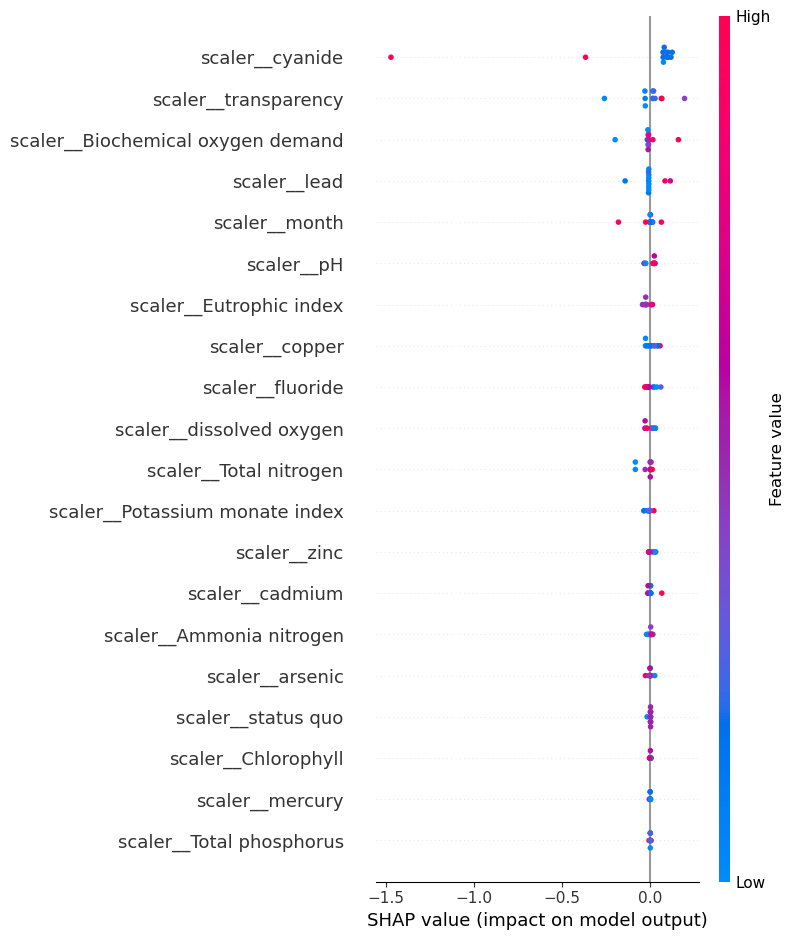

{'algorithm': ['GBT with RFE'],
 'MAE Test': [0.08735713931515847],
 'R² Test': [0.8116350699705145],
 'MSE Test': [0.01259642021802115],
 'RMSE Test': [0.11223377485419062]}

In [44]:
# SHAP Integration
explainer = shap.TreeExplainer(best_model_gbt_rfe.named_steps.model.regressor_.estimator_)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_selected)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names)

# LIME Integration
lime_explainer = LimeTabularExplainer(
    training_data=X_train_selected, 
    feature_names=selected_feature_names, 
    class_names=['target'], 
    mode='regression'
)

# Predictions and evaluation on test set
y_pred_gbt = best_model_gbt_rfe.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred_gbt)
r2 = r2_score(y_test, y_pred_gbt)

mse = mean_squared_error(y_test, y_pred_gbt)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_GBT = {
    'algorithm': ['GBT with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_GBT


In [45]:
i = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_selected[i], 
    predict_fn=best_model_gbt_rfe.named_steps.model.regressor_.estimator_.predict
)

lime_exp.show_in_notebook()

In [46]:
# Initialize AdaBoost with DecisionTreeRegressor as the base estimator
base_estimator = DecisionTreeRegressor(random_state=42)
ada = AdaBoostRegressor(estimator=base_estimator, random_state=42)

# Applying standardization to the features
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Defining target transformation
target_transformer = TransformedTargetRegressor(regressor=ada, func=np.log, inverse_func=np.exp)

# Define the pipeline
pipeline = Pipeline([('preprocess', transformer), ('transform_target', target_transformer)])

# Hyperparameter tuning
param_grid = {
    'transform_target__regressor__n_estimators': [50, 100, 200],
    'transform_target__regressor__learning_rate': [0.01, 0.1, 1],
    'transform_target__regressor__estimator__max_depth': [3, 5, 10],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
model = grid_search.fit(X=X_train, y=y_train)
best_model_ada = model.best_estimator_

# Predict on the test set
y_pred_ada = best_model_ada.predict(X_test)

# Calculate Mean Absolute Error for the test set
mae = mean_absolute_error(y_test, y_pred_ada)

# Calculate R² Score for the test set
r2 = r2_score(y_test, y_pred_ada)

mse = mean_squared_error(y_test, y_pred_gbt)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_ada = {
    'algorithm': ['AdaBoost'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_ada
r2_accuracy.append(r2)
mse_accuracy.append(mse_n)
rmse_accuracy.append(rmse_n)
mae_accuracy.append(mae_n)
algorithm_name.append('Adaboost')

In [47]:
# Initialize AdaBoost with DecisionTreeRegressor as the base estimator
base_estimator = DecisionTreeRegressor(random_state=42)
ada = AdaBoostRegressor(estimator=base_estimator, random_state=42)

# Applying standardization to the features
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Apply preprocessing to the data
X_train_preprocessed = transformer.fit_transform(X_train)
X_test_preprocessed = transformer.transform(X_test)

# Perform RFE separately to select features
rfe = RFE(estimator=base_estimator, n_features_to_select=21)
rfe.fit(X_train_preprocessed, y_train)

# Get the names of the selected features
selected_feature_names = np.array(transformer.get_feature_names_out())[rfe.support_]
print("Selected feature names: ", selected_feature_names)

# Now use the selected features for the final model
X_train_selected = rfe.transform(X_train_preprocessed)
X_test_selected = rfe.transform(X_test_preprocessed)

# Define target transformation with AdaBoost
target_transformer = TransformedTargetRegressor(regressor=ada, func=np.log, inverse_func=np.exp)

# Define the pipeline with the selected features
pipeline = Pipeline([('model', target_transformer)])

# Hyperparameter tuning
param_grid = {
    'model__regressor__n_estimators': [50, 100, 200],
    'model__regressor__learning_rate': [0.01, 0.1, 1],
    'model__regressor__estimator__max_depth': [3, 5, 10],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
model = grid_search.fit(X=X_train_selected, y=y_train)
best_model_ada_rfe = model.best_estimator_

# Predict on the test set
y_pred_ada = best_model_ada_rfe.predict(X_test_selected)

# Calculate Mean Absolute Error for the test set
mae = mean_absolute_error(y_test, y_pred_ada)

# Calculate R² Score for the test set
r2 = r2_score(y_test, y_pred_ada)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred_ada)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_ada = {
    'algorithm': ['AdaBoost with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_ada
r2_accuracy_rfe.append(r2)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('AdaBoost with RFE')

Selected feature names:  ['scaler__month' 'scaler__pH' 'scaler__dissolved oxygen'
 'scaler__Potassium monate index' 'scaler__Biochemical oxygen demand'
 'scaler__Ammonia nitrogen' 'scaler__Total phosphorus'
 'scaler__Total nitrogen' 'scaler__copper' 'scaler__zinc'
 'scaler__fluoride' 'scaler__arsenic' 'scaler__mercury' 'scaler__lead'
 'scaler__cyanide' 'scaler__Petroleum' 'scaler__Anionic surfactants'
 'scaler__Chlorophyll' 'scaler__transparency' 'scaler__Eutrophic index'
 'onehot__region_Sihong County']


In [48]:
best_model_ada_rfe.named_steps.model.regressor_.estimator_

DecisionTreeRegressor(max_depth=5, random_state=42)

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/12 [00:00<?, ?it/s]

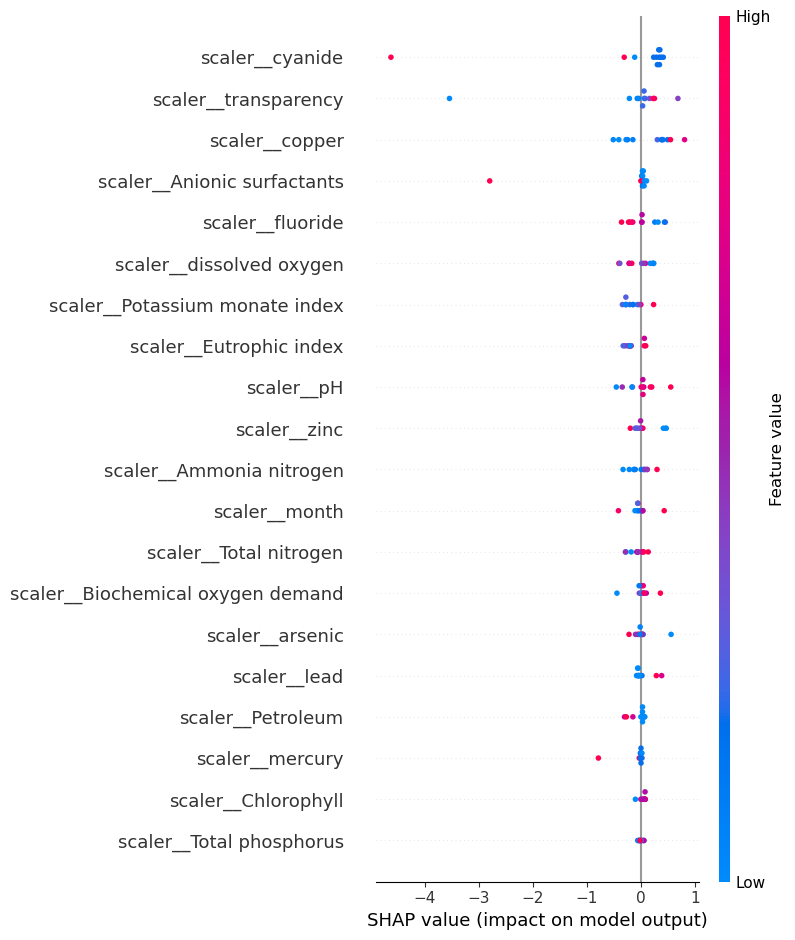

{'algorithm': ['AdaBoost with RFE'],
 'MAE Test': [0.09356533606572903],
 'R² Test': [0.7910066771236127],
 'MSE Test': [0.013975890933091742],
 'RMSE Test': [0.11821967236078665]}

In [49]:
# Check if the model is tree-based; if not, use KernelExplainer
try:
    explainer = shap.TreeExplainer(best_model_ada_rfe.named_steps.model.regressor_.estimator_)
    shap_values = explainer.shap_values(X_test_selected)
except AttributeError:
    explainer = shap.KernelExplainer(best_model_ada_rfe.predict, X_train_selected)
    shap_values = explainer.shap_values(X_test_selected)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names)

# LIME Integration
lime_explainer = LimeTabularExplainer(
    training_data=X_train_selected, 
    feature_names=selected_feature_names, 
    class_names=['target'], 
    mode='regression'
)

# Predictions and evaluation on test set
y_pred_ada = best_model_ada_rfe.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred_ada)
r2 = r2_score(y_test, y_pred_ada)

mse = mean_squared_error(y_test, y_pred_ada)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_ada = {
    'algorithm': ['AdaBoost with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_ada



In [50]:
i = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_selected[i], 
    predict_fn=best_model_ada_rfe.predict 
)

# Display the LIME explanation in the notebook
lime_exp.show_in_notebook()


In [51]:
# Define the preprocessing steps
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Define the CatBoostRegressor
catboost = CatBoostRegressor(random_state=42, verbose=0)

# Define the transformed target regressor
target_transformer = TransformedTargetRegressor(regressor=catboost, func=np.log, inverse_func=np.exp)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), ('target_transformer', target_transformer)])

# Define the hyperparameter grid for grid search
param_grid = {
    'target_transformer__regressor__learning_rate': [0.01, 0.05, 0.1],
    'target_transformer__regressor__depth': [4, 6, 10],
    'target_transformer__regressor__iterations': [100, 300, 500],
    'target_transformer__regressor__l2_leaf_reg': [1, 3, 5],
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
model = grid_search.fit(X_train, y_train)
best_model_cat = model.best_estimator_

# Predictions and evaluation on test set
y_pred_catboost = best_model_cat.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_catboost)
r2 = r2_score(y_test, y_pred_catboost)

mse = mean_squared_error(y_test, y_pred_catboost)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_catboost = {
    'algorithm': ['CatBoost'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_catboost
r2_accuracy.append(r2)
mse_accuracy.append(mse_n)
rmse_accuracy.append(rmse_n)
mae_accuracy.append(mae_n)
algorithm_name.append('CatBoost')


In [52]:
# Define the preprocessing steps
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Apply preprocessing to the data
X_train_preprocessed = transformer.fit_transform(X_train)
X_test_preprocessed = transformer.transform(X_test)

# Initialize CatBoostRegressor
catboost = CatBoostRegressor(random_state=42, verbose=0)
# Perform RFE separately to select features
rfe = RFE(estimator=catboost, n_features_to_select=7)
rfe.fit(X_train_preprocessed, y_train)

# Get the names of the selected features
selected_feature_names = np.array(transformer.get_feature_names_out())[rfe.support_]
print("Selected feature names: ", selected_feature_names)

# Now use the selected features for the final model
X_train_selected = rfe.transform(X_train_preprocessed)
X_test_selected = rfe.transform(X_test_preprocessed)

# Define target transformation with CatBoost
target_transformer = TransformedTargetRegressor(regressor=catboost, func=np.log, inverse_func=np.exp)

# Define the pipeline with the selected features
pipeline = Pipeline([('model', target_transformer)])

# Hyperparameter tuning
param_grid = {
    'model__regressor__learning_rate': [0.01, 0.05, 0.1],
    'model__regressor__depth': [4, 6, 10],
    'model__regressor__iterations': [100, 300, 500],
    'model__regressor__l2_leaf_reg': [1, 3, 5],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
model = grid_search.fit(X=X_train_selected, y=y_train)
best_model_cat_rfe = model.best_estimator_

# Predict on the test set
y_pred_catboost = best_model_cat_rfe.predict(X_test_selected)

# Calculate Mean Absolute Error for the test set
mae = mean_absolute_error(y_test, y_pred_catboost)

# Calculate R² Score for the test set
r2 = r2_score(y_test, y_pred_catboost)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred_catboost)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_catboost = {
    'algorithm': ['CatBoost with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_catboost
r2_accuracy_rfe.append(r2)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('CatBoost with RFE')


Selected feature names:  ['scaler__month' 'scaler__pH' 'scaler__dissolved oxygen' 'scaler__copper'
 'scaler__fluoride' 'scaler__cyanide' 'scaler__transparency']


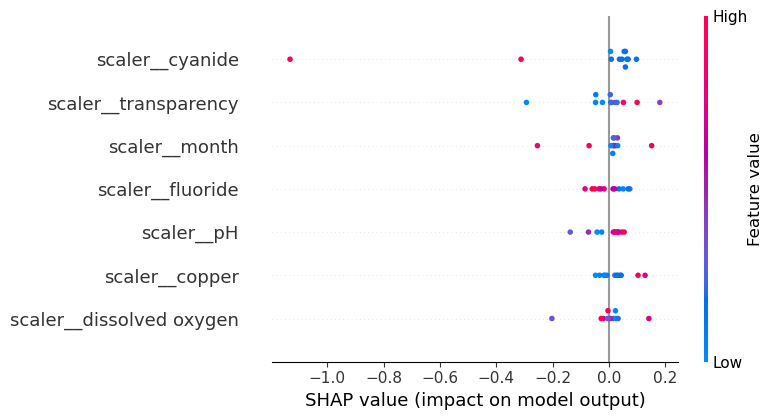

{'algorithm': ['CatBoost with RFE'],
 'MAE Test': [0.09918066680588428],
 'R² Test': [0.8114761112691504],
 'MSE Test': [0.012607050172330471],
 'RMSE Test': [0.11228112117506875]}

In [53]:
# SHAP Integration
# Create the SHAP explainer using the selected model
explainer = shap.TreeExplainer(best_model_cat_rfe.named_steps['model'].regressor_)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_selected)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names)

# LIME Integration
# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_selected, 
    feature_names=selected_feature_names, 
    class_names=['target'], 
    mode='regression'
)

# Calculate Mean Absolute Error for the test set
mae = mean_absolute_error(y_test, y_pred_catboost)

# Calculate R² Score for the test set
r2 = r2_score(y_test, y_pred_catboost)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred_catboost)
rmse = np.sqrt(mse)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae / range_y_test
mse_n = mse / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse / range_y_test

# Save results
res_catboost = {
    'algorithm': ['CatBoost with RFE'],
    'MAE Test': [mae_n],
    'R² Test': [r2],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_catboost


In [54]:
# Explain an instance from the test set using LIME
# Let's explain the first instance in the test set
i = 0  # index of the instance
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_selected[i], 
    predict_fn=best_model_cat_rfe.predict
)

# Show the explanation
lime_exp.show_in_notebook()

In [55]:
# Define the preprocessing steps
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Base Learners
base_learners = [
    ('xgb', best_model_xgb_rfe),  # XGBRegressor with RFE from your provided code
    ('gbt', best_model_gbt_rfe),  # GradientBoostingRegressor with RFE from your provided code
    ('catboost', best_model_cat_rfe)  # CatBoostRegressor with RFE from your provided code
]

# Meta-Learner
meta_learner = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Define the Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True  # Allows meta-learner to access original features
)

# Define the pipeline
pipeline = Pipeline(steps=[('transformer', transformer),
                           ('stacking_regressor', stacking_regressor)])

# Hyperparameter tuning for the meta-learner (AdaBoost)
param_grid = {
    'stacking_regressor__final_estimator__n_estimators': [50, 100, 200],
    'stacking_regressor__final_estimator__learning_rate': [0.01, 0.1, 0.5],
    'stacking_regressor__final_estimator__estimator__max_depth': [2, 3, 5]
}

# Fine-tuning using GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit the model
model = grid_search.fit(X_train, y_train)
best_model = model.best_estimator_

# Predict on the test set
y_pred_stack = best_model.predict(X_test)

# Calculate Mean Absolute Error for the test set
mae_stack = mean_absolute_error(y_test, y_pred_stack)

# Calculate R² Score for the test set
r2_stack = r2_score(y_test, y_pred_stack)

# Calculate MSE and RMSE
mse_stack = mean_squared_error(y_test, y_pred_stack)
rmse_stack = np.sqrt(mse_stack)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae_stack / range_y_test
mse_n = mse_stack / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse_stack / range_y_test

# Save results
res_stack = {
    'algorithm': ['Stacking Regressor'],
    'MAE Test': [mae_n],
    'R² Test': [r2_stack],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_stack
r2_accuracy_rfe.append(r2_stack)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('Stacking Regressor')


In [56]:
# Define the preprocessing steps
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Eutrophication', 'region'])
], remainder='passthrough')

# Base Learners (assuming these are already fitted models)
base_learners = [
    ('xgb', best_model_xgb_rfe),  # XGBRegressor with RFE
    ('gbt', best_model_gbt_rfe),  # GradientBoostingRegressor with RFE
    ('catboost', best_model_cat_rfe)  # CatBoostRegressor with RFE
]

# Define the Voting Regressor
voting_regressor = VotingRegressor(estimators=base_learners, n_jobs=-1)

# Define the pipeline
pipeline = Pipeline(steps=[('transformer', transformer),
                           ('voting_regressor', voting_regressor)])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_voting = pipeline.predict(X_test)

# Calculate Mean Absolute Error for the test set
mae_voting = mean_absolute_error(y_test, y_pred_voting)

# Calculate R² Score for the test set
r2_voting = r2_score(y_test, y_pred_voting)

# Calculate MSE and RMSE
mse_voting = mean_squared_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mse_voting)

# Calculate the range of the target variable in the test set
range_y_test = y_test.max() - y_test.min()

# Normalize the metrics by dividing by the range of y_test
mae_n = mae_voting / range_y_test
mse_n = mse_voting / (range_y_test ** 2)  # MSE should be divided by the square of the range
rmse_n = rmse_voting / range_y_test

# Save results
res_voting = {
    'algorithm': ['Voting Regressor'],
    'MAE Test': [mae_n],
    'R² Test': [r2_voting],
    'MSE Test': [mse_n],
    'RMSE Test': [rmse_n]
}

res_voting
r2_accuracy_rfe.append(r2_voting)
mse_accuracy_rfe.append(mse_n)
rmse_accuracy_rfe.append(rmse_n)
mae_accuracy_rfe.append(mae_n)
algorithm_name_rfe.append('Voting Regressor')


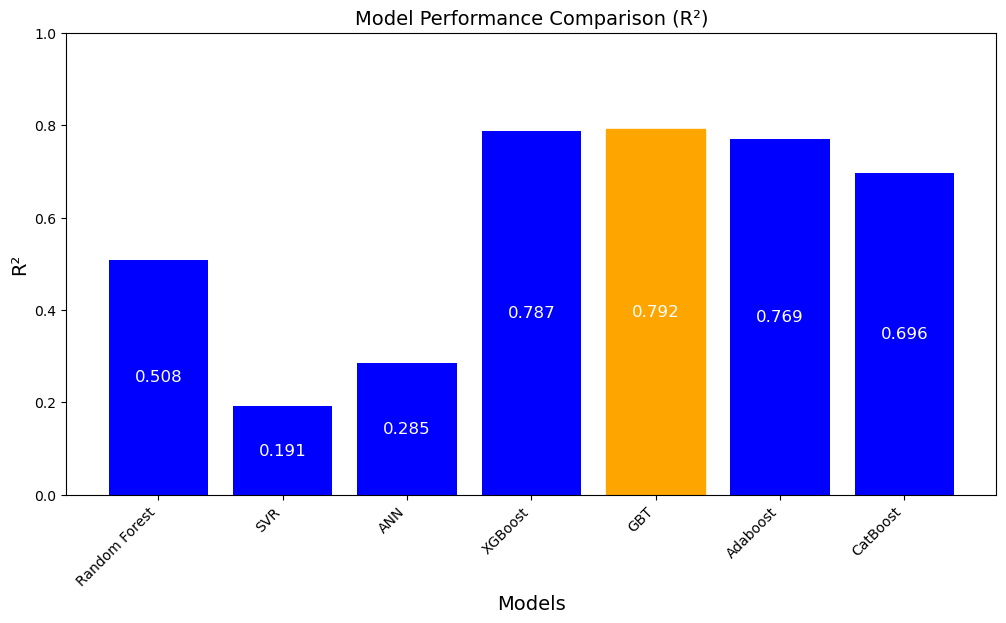

In [57]:
best_model_index = np.argmax(r2_accuracy)
best_model_r2 = r2_accuracy[best_model_index]

plt.figure(figsize=(12, 6))
bars = plt.bar(algorithm_name, r2_accuracy, color='blue')

# Set the best model's bar color to green
bars[best_model_index].set_color('orange')

# Annotate bars with R² accuracy values at the center of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{r2_accuracy[i]:.3f}', ha='center', va='center', color='white', fontsize=12)

# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Model Performance Comparison (R²)', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylabel('R²', fontsize=14)

# Set y-axis limits
plt.ylim(0, 1.0)

# Show the plot
plt.show()


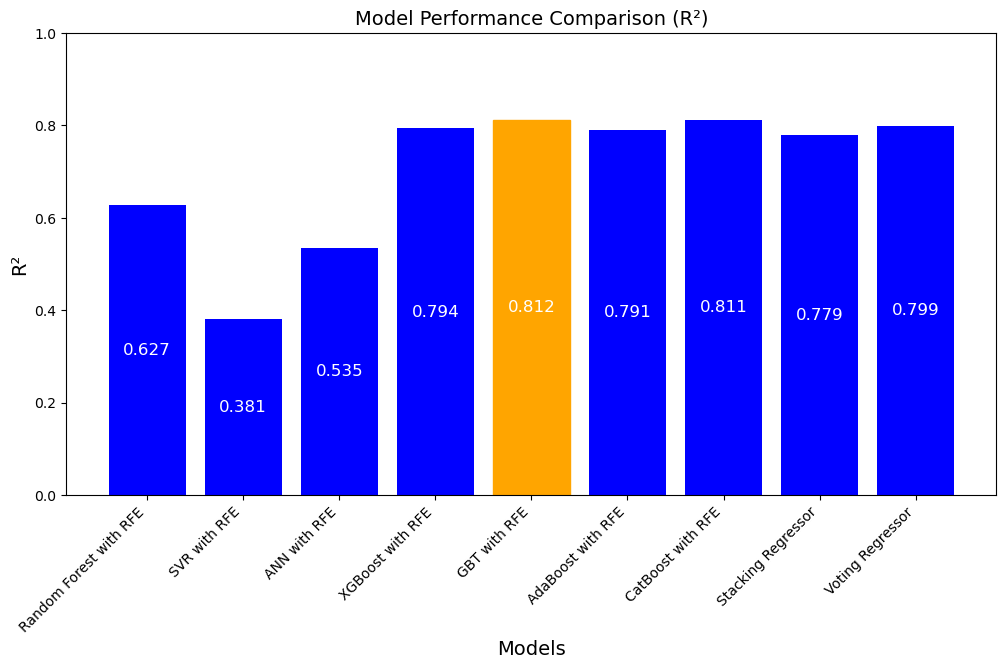

In [58]:
best_model_index = np.argmax(r2_accuracy_rfe)
best_model_r2 = r2_accuracy_rfe[best_model_index]

plt.figure(figsize=(12, 6))
bars = plt.bar(algorithm_name_rfe, r2_accuracy_rfe, color='blue')

# Set the best model's bar color to green
bars[best_model_index].set_color('orange')

# Annotate bars with R² accuracy values at the center of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{r2_accuracy_rfe[i]:.3f}', ha='center', va='center', color='white', fontsize=12)

# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Model Performance Comparison (R²)', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylabel('R²', fontsize=14)

# Set y-axis limits
plt.ylim(0, 1.0)

# Show the plot
plt.show()


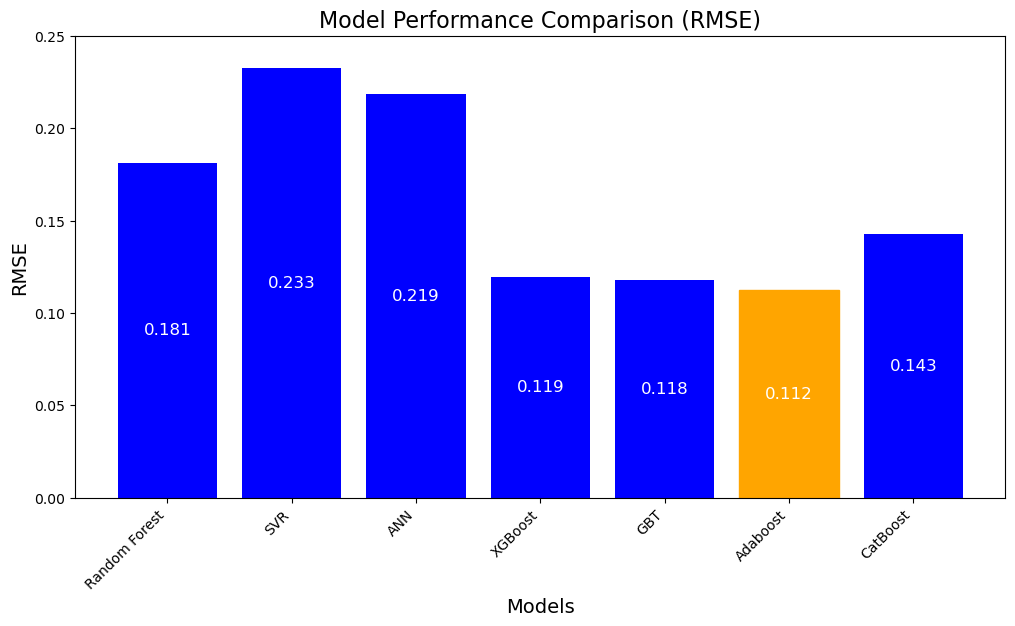

In [59]:
best_model_index = np.argmin(rmse_accuracy)
best_model_r2 = rmse_accuracy[best_model_index]

plt.figure(figsize=(12, 6))
bars = plt.bar(algorithm_name, rmse_accuracy, color='blue')
best_model_index
# Set the best model's bar color to green
bars[best_model_index].set_color('orange')

# Annotate bars with R² accuracy values at the center of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{rmse_accuracy[i]:.3f}', ha='center', va='center', color='white', fontsize=12)

# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Model Performance Comparison (RMSE)', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

# Set y-axis limits
plt.ylim(0, 0.25)

# Show the plot
plt.show()


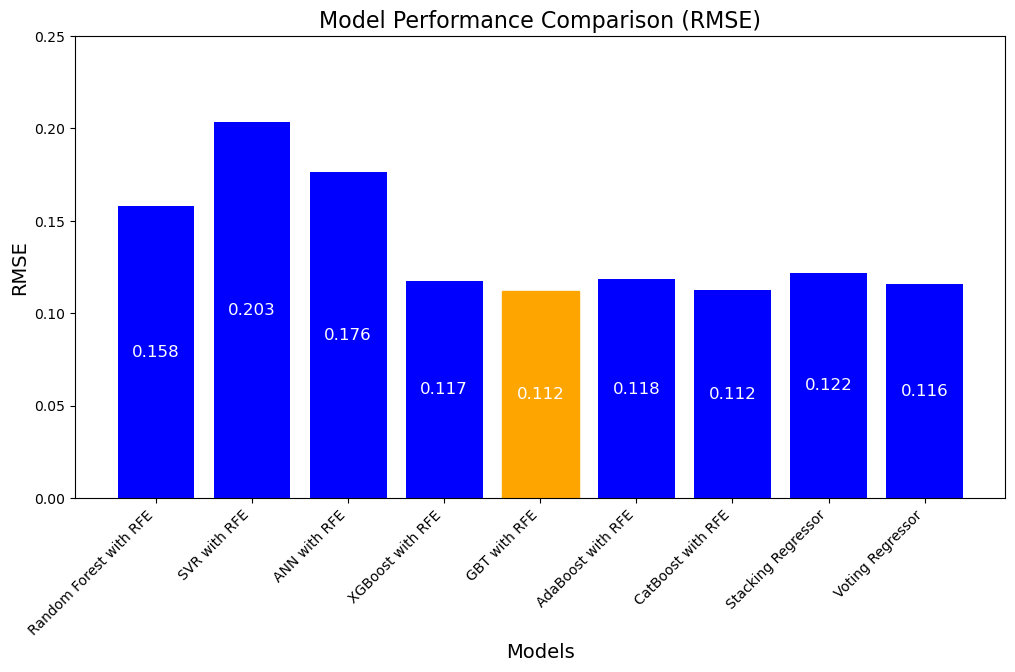

In [60]:
best_model_index = np.argmin(rmse_accuracy_rfe)
best_model_r2 = rmse_accuracy_rfe[best_model_index]

plt.figure(figsize=(12, 6))
bars = plt.bar(algorithm_name_rfe, rmse_accuracy_rfe, color='blue')
best_model_index
# Set the best model's bar color to green
bars[best_model_index].set_color('orange')

# Annotate bars with R² accuracy values at the center of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{rmse_accuracy_rfe[i]:.3f}', ha='center', va='center', color='white', fontsize=12)

# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Model Performance Comparison (RMSE)', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

# Set y-axis limits
plt.ylim(0, 0.25)

# Show the plot
plt.show()


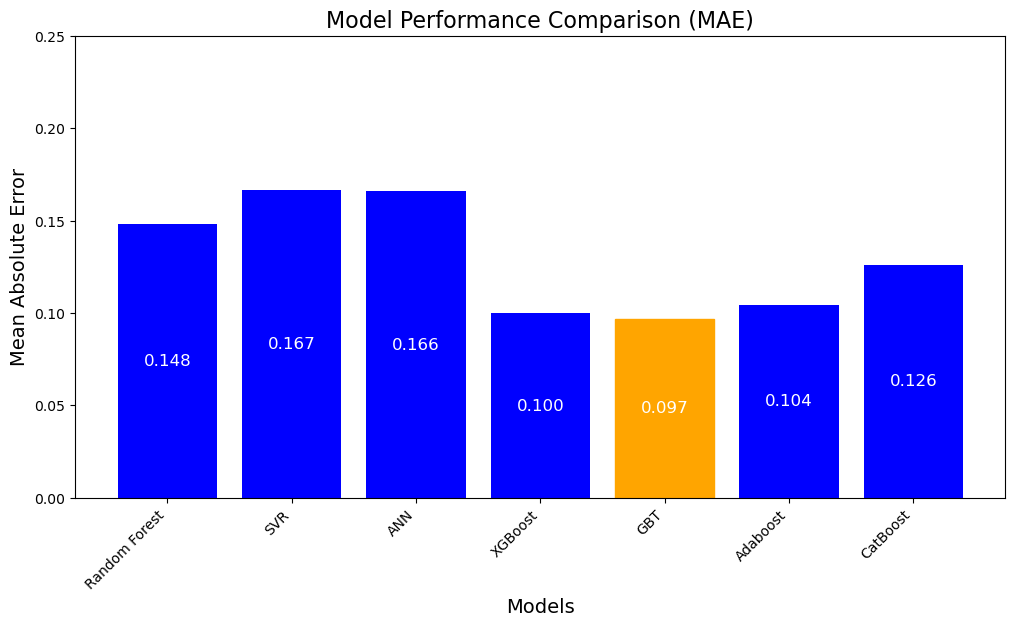

In [61]:
best_model_index = np.argmin(mae_accuracy)
best_model_r2 = mae_accuracy[best_model_index]

plt.figure(figsize=(12, 6))
bars = plt.bar(algorithm_name, mae_accuracy, color='blue')
best_model_index
# Set the best model's bar color to green
bars[best_model_index].set_color('orange')

# Annotate bars with R² accuracy values at the center of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{mae_accuracy[i]:.3f}', ha='center', va='center', color='white', fontsize=12)

# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Model Performance Comparison (MAE)', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)

# Set y-axis limits
plt.ylim(0, 0.25)

# Show the plot
plt.show()


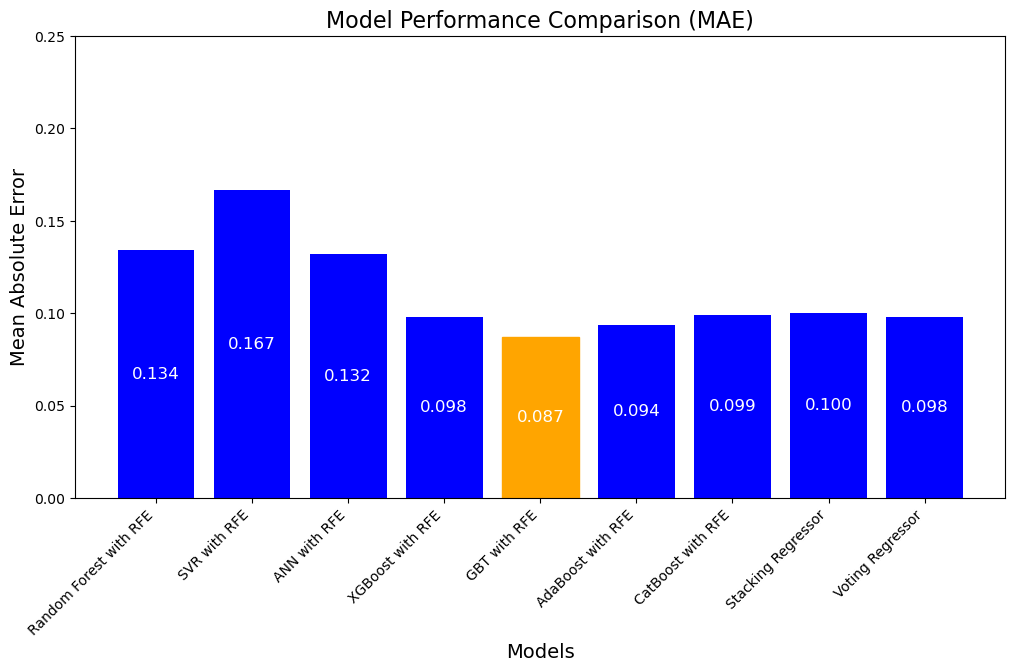

In [62]:
best_model_index = np.argmin(mae_accuracy_rfe)
best_model_r2 = mae_accuracy_rfe[best_model_index]

plt.figure(figsize=(12, 6))
bars = plt.bar(algorithm_name_rfe, mae_accuracy_rfe, color='blue')
best_model_index
# Set the best model's bar color to green
bars[best_model_index].set_color('orange')

# Annotate bars with R² accuracy values at the center of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{mae_accuracy_rfe[i]:.3f}', ha='center', va='center', color='white', fontsize=12)

# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Model Performance Comparison (MAE)', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)

# Set y-axis limits
plt.ylim(0, 0.25)

# Show the plot
plt.show()


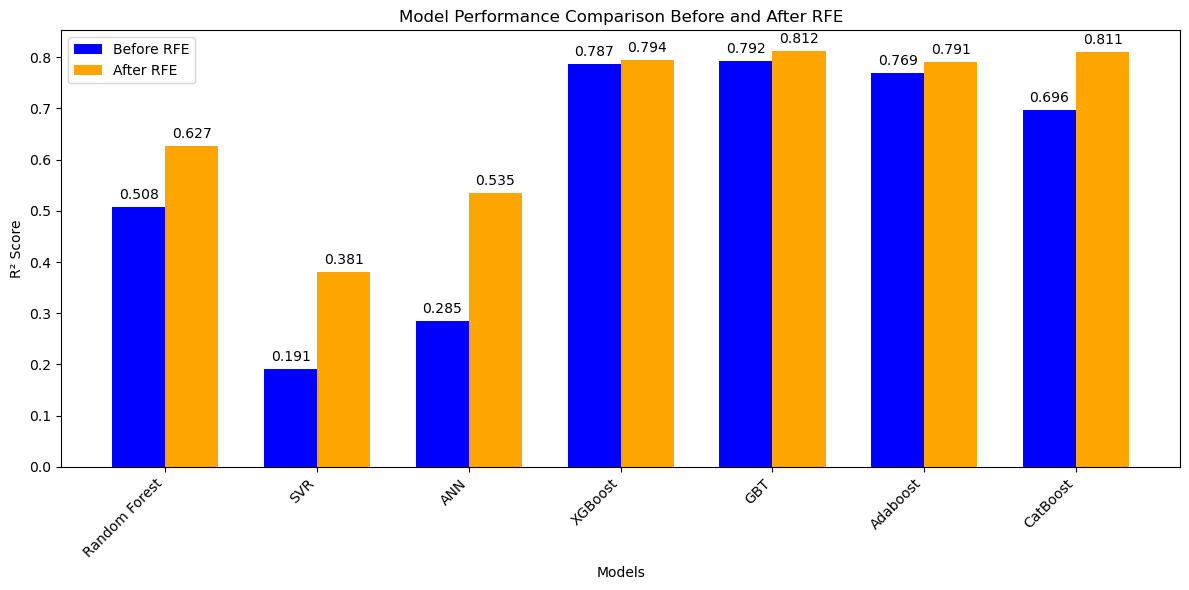

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Data for before and after RFE
models = ['Random Forest', 'SVR', 'ANN', 'XGBoost', 'GBT', 'Adaboost', 'CatBoost']
r2_before_rfe = [0.508, 0.191, 0.285, 0.787, 0.792, 0.769, 0.696]  # Add NaN for stacking and voting
r2_after_rfe = [0.627, 0.381, 0.535, 0.794, 0.812, 0.791, 0.811]

x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35

# Plotting before RFE
bars1 = ax.bar(x - bar_width/2, r2_before_rfe, bar_width, label='Before RFE', color='blue')

# Plotting after RFE
bars2 = ax.bar(x + bar_width/2, r2_after_rfe, bar_width, label='After RFE', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison Before and After RFE')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Add labels on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval):  # Don't plot labels for NaN bars
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()
plt.show()


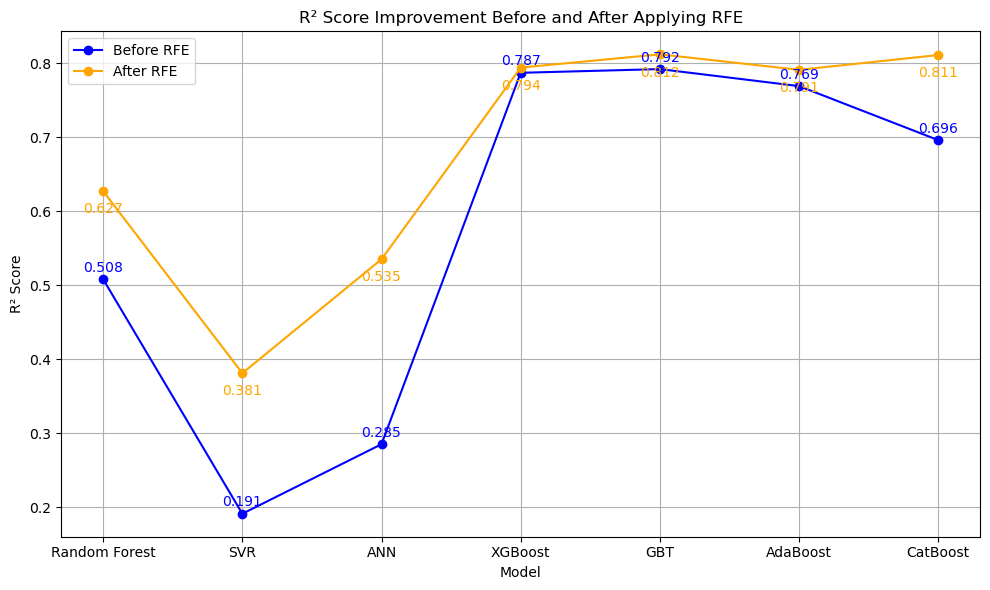

In [69]:
import matplotlib.pyplot as plt

# Sample data: R² scores before and after RFE for each model
models = ['Random Forest', 'SVR', 'ANN', 'XGBoost', 'GBT', 'AdaBoost', 'CatBoost']
r2_before_rfe = [0.508, 0.191, 0.285, 0.787, 0.792, 0.769, 0.696]  # Add NaN for stacking and voting
r2_after_rfe = [0.627, 0.381, 0.535, 0.794, 0.812, 0.791, 0.811]

# Create a plot for R² score improvement
plt.figure(figsize=(10, 6))
plt.plot(models, r2_before_rfe, marker='o', linestyle='-', color='blue', label='Before RFE')
plt.plot(models, r2_after_rfe, marker='o', linestyle='-', color='orange', label='After RFE')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('R² Score Improvement Before and After Applying RFE')
plt.legend()
plt.grid(True)

# Annotate the points with the exact scores
for i, model in enumerate(models):
    plt.text(i, r2_before_rfe[i] + 0.01, f'{r2_before_rfe[i]:.3f}', ha='center', color='blue')
    plt.text(i, r2_after_rfe[i] - 0.03, f'{r2_after_rfe[i]:.3f}', ha='center', color='orange')

plt.tight_layout()
plt.show()
